In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

# Pre-processing of the images

In [ ]:
img_rows, img_cols = 224, 224
channel_depth = 3
input_shape = (img_rows,img_cols,channel_depth)
model_input = Input(shape=input_shape)


train_path="swatdcnn/data/Augmented/stage_2/train"
test_path="swatdcnn/test/stage-2/test"
val_path="swatdcnn/data/Augmented/stage_2/validation"

In [ ]:
IMG_SIZE = (224,224)

def ImgDataGen(file_path,f=False):    
    file_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    file_set = file_datagen.flow_from_directory(
        file_path,
        target_size = IMG_SIZE,
        batch_size = 16,
        class_mode = 'categorical',
        shuffle = f
    )
    return file_set

In [ ]:
training_set, test_set, val_set = ImgDataGen(train_path, f=True), ImgDataGen(test_path), ImgDataGen(val_path)

In [ ]:
nb_train_samples = len(training_set.filenames)
nb_validation_samples = len(val_set.filenames)
nb_test_samples = len(test_set.filenames)
num_classes= len(training_set.class_indices)
labels = [i for i in training_set.class_indices]
print(labels)

# Training using VGG16

In [ ]:
def my_model(model_input):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=model_input)
    for layer in vgg16.layers:layer.trainable = False
    # our layers - you can add more if you want
    y = GlobalAveragePooling2D()(vgg16.output)
    y = Dense(512, activation='relu', use_bias=True)(y)
    y = Dropout(0.5)(y)
    prediction = Dense(num_classes,activation='softmax')(y)
    model = Model(inputs=vgg16.input, outputs=prediction, name='VGG16')
    # tell the model what cost and optimization method to use
    return model

In [ ]:
model = my_model(model_input)
# model.summary()

In [ ]:
#MODEL COMPILATION WITH HYPER-PARAMETERS, LOSS FUNCTIONS AND TRAINING!
import time

batch_size = 16

epochs = 25

start_time = time.time()

optimizer = Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
) 

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.5, 
    patience=2,                          
    verbose=1, 
    mode='max', 
    min_lr=0.000001
)

callbacks = [reduce_lr]

history = model.fit(
    training_set,
    epochs=epochs, 
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=val_set,
    callbacks=callbacks, 
    validation_steps=nb_validation_samples // batch_size, 
    verbose=1
)

elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))


Epoch 1/25
375/375 [==============================] - 190s 504ms/step - loss: 0.7720 - accuracy: 0.6602 - val_loss: 0.4996 - val_accuracy: 0.8205 - lr: 1.0000e-04
Epoch 2/25
375/375 [==============================] - 172s 459ms/step - loss: 0.4837 - accuracy: 0.8133 - val_loss: 0.3899 - val_accuracy: 0.8542 - lr: 1.0000e-04
Epoch 3/25
375/375 [==============================] - 170s 455ms/step - loss: 0.3966 - accuracy: 0.8470 - val_loss: 0.3383 - val_accuracy: 0.8654 - lr: 1.0000e-04
Epoch 4/25
375/375 [==============================] - 171s 457ms/step - loss: 0.3481 - accuracy: 0.8577 - val_loss: 0.3119 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 5/25
375/375 [==============================] - 169s 451ms/step - loss: 0.3146 - accuracy: 0.8720 - val_loss: 0.2965 - val_accuracy: 0.8702 - lr: 1.0000e-04
Epoch 6/25
375/375 [==============================] - ETA: 0s - loss: 0.2953 - accuracy: 0.8773
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
375/375 [====

'01:11:35'

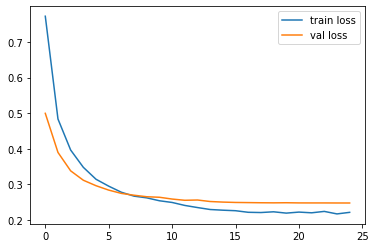

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('vgg-loss-rps-1.png')
plt.show()

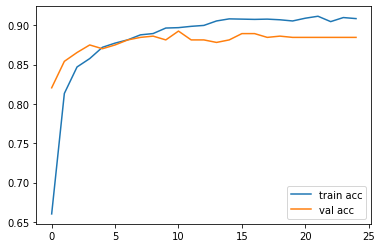

In [ ]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('vgg-acc-rps-1.png')
plt.show()

In [ ]:
def report_test(test_set,model=model):
    
    # evaluating test
    model.evaluate(test_set,batch_size=32)
    y_pred=model.predict(test_set)
    y_pred=np.argmax(y_pred,axis=1)
    accuracy_score(y_pred,test_set.classes)
    print(classification_report(y_pred,test_set.classes))
    
    # confusion_matrix
    labels = [i for i in training_set.class_indices]
    cm =confusion_matrix(y_pred, test_set.classes)
    disp = ConfusionMatrixDisplay(cm,display_labels=labels)
    disp.plot(cmap='Blues',xticks_rotation='vertical')
    plt.show()

report_test(test_set)

# Export the Model

In [ ]:
file_model = "VGG16_2.h5"
tf.keras.models.save_model(model,file_model)

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
path = 'history/'
# save to json:  
hist_json_file = 'VGG16_2.json' 
with open(path+hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'VGG16_2.csv'
with open(path+hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)